# Smart Claim BPJS - Fraud Detection Model Training

Notebook ini digunakan untuk melatih model Random Forest untuk deteksi fraud pada klaim BPJS.

## Tahapan:
1. Generate dummy training data
2. Data cleaning dan preprocessing
3. Feature engineering
4. Train/test split
5. Model training (Random Forest)
6. Evaluation
7. Save model

In [1]:
import pandas as pd
import numpy as np
import json
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Add parent directory to path
sys.path.append('..')
from utils.data_generator import *

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1. Generate Training Data

Generate 1500 dummy samples:
- 800 legitimate claims (label=0)
- 700 fraudulent claims (label=1)

In [2]:
def generate_training_sample(is_fraud=False):
    """
    Generate a single training sample
    
    Args:
        is_fraud: If True, generate fraudulent claim; else legitimate
    """
    diagnosis = generate_diagnosis()
    severity_map = {'mild': 1, 'moderate': 2, 'severe': 3}
    diagnosis_severity = severity_map[diagnosis['severity']]
    
    if is_fraud:
        # Fraudulent claim: inconsistencies
        # 1. Mild diagnosis but severe vitals/labs
        # 2. Severe diagnosis but normal vitals/labs
        # 3. Inflated claim amount
        
        fraud_type = np.random.choice(['upcoding', 'phantom', 'inconsistent'])
        
        if fraud_type == 'upcoding':
            # Mild diagnosis but high claim
            diagnosis['severity'] = 'mild'
            diagnosis_severity = 1
            vital_signs = generate_vital_signs(False)  # Normal vitals
            lab_results = generate_lab_results(False)  # Normal labs
            claim_amount = generate_claim_amount('severe') * np.random.uniform(1.5, 3.0)
        elif fraud_type == 'phantom':
            # Severe diagnosis but normal findings
            diagnosis['severity'] = 'severe'
            diagnosis_severity = 3
            vital_signs = generate_vital_signs(False)  # Normal vitals (suspicious!)
            lab_results = generate_lab_results(False)  # Normal labs (suspicious!)
            claim_amount = generate_claim_amount('severe')
        else:
            # Random inconsistencies
            vital_signs = generate_vital_signs(np.random.choice([True, False]))
            lab_results = generate_lab_results(np.random.choice([True, False]))
            claim_amount = generate_claim_amount(diagnosis['severity']) * np.random.uniform(1.2, 2.5)
    else:
        # Legitimate claim: consistent data
        abnormal = diagnosis['severity'] in ['moderate', 'severe']
        vital_signs = generate_vital_signs(abnormal)
        lab_results = generate_lab_results(diagnosis['severity'] == 'severe')
        claim_amount = generate_claim_amount(diagnosis['severity']) * np.random.uniform(0.8, 1.2)
    
    # Create feature dict
    features = {
        'diagnosis_severity': diagnosis_severity,
        'systolic_bp': vital_signs['systolic_bp'],
        'diastolic_bp': vital_signs['diastolic_bp'],
        'temperature': vital_signs['temperature'],
        'pulse': vital_signs['pulse'],
        'respiratory_rate': vital_signs['respiratory_rate'],
        'hemoglobin': lab_results['hemoglobin'],
        'leukocyte': lab_results['leukocyte'],
        'platelet': lab_results['platelet'],
        'hematocrit': lab_results['hematocrit'],
        'claim_amount': int(claim_amount),
        'is_fraud': 1 if is_fraud else 0
    }
    
    return features

# Generate dataset
print("Generating training data...")
data = []

# Generate legitimate claims
for i in range(800):
    data.append(generate_training_sample(is_fraud=False))

# Generate fraudulent claims
for i in range(700):
    data.append(generate_training_sample(is_fraud=True))

# Create DataFrame
df = pd.DataFrame(data)

print(f"✓ Generated {len(df)} samples")
print(f"  - Legitimate: {(df['is_fraud']==0).sum()}")
print(f"  - Fraudulent: {(df['is_fraud']==1).sum()}")
print(f"\nDataset shape: {df.shape}")
df.head()

Generating training data...
✓ Generated 1500 samples
  - Legitimate: 800
  - Fraudulent: 700

Dataset shape: (1500, 12)


,diagnosis_severity,systolic_bp,diastolic_bp,temperature,pulse,respiratory_rate,hemoglobin,leukocyte,platelet,hematocrit,claim_amount,is_fraud
0,2,148,110,39.6,103,26,15.1,9855,257529,46,4383333,0
1,3,161,107,38.9,127,27,11.4,3236,107515,33,11286668,0
2,3,180,101,38.7,115,26,11.7,2194,52397,36,13252782,0
3,1,110,75,36.5,66,18,14.8,7221,325132,46,870752,0
4,3,172,97,38.9,116,26,9.6,2638,59006,32,14820522,0


## 2. Data Exploration

In [3]:
# Basic statistics
print("Dataset Info:")
print(df.info())
print("\nBasic Statistics:")
df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   diagnosis_severity  1500 non-null   int64  
 1   systolic_bp         1500 non-null   int64  
 2   diastolic_bp        1500 non-null   int64  
 3   temperature         1500 non-null   float64
 4   pulse               1500 non-null   int64  
 5   respiratory_rate    1500 non-null   int64  
 6   hemoglobin          1500 non-null   float64
 7   leukocyte           1500 non-null   int64  
 8   platelet            1500 non-null   int64  
 9   hematocrit          1500 non-null   int64  
 10  claim_amount        1500 non-null   int64  
 11  is_fraud            1500 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 140.8 KB
None

Basic Statistics:


,diagnosis_severity,systolic_bp,diastolic_bp,temperature,pulse,respiratory_rate,hemoglobin,leukocyte,platelet,hematocrit,claim_amount,is_fraud
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1.500000e+03,1500.000000
mean,2.024667,135.079333,86.199333,37.626733,90.370000,23.090000,13.378400,5810.566667,223149.934667,41.874000,1.138173e+07,0.466667
std,0.944097,21.221654,12.218802,1.214016,20.963351,5.744554,2.012181,2410.741318,106305.688107,5.730854,1.123709e+07,0.499054
min,1.000000,110.000000,70.000000,36.000000,60.000000,16.000000,9.000000,2000.000000,50164.000000,30.000000,1.778660e+05,0.000000
25%,1.000000,118.000000,76.000000,36.600000,73.000000,19.000000,11.600000,3336.000000,112568.500000,38.000000,1.080969e+06,0.000000
50%,2.000000,126.000000,82.000000,37.200000,85.000000,21.000000,13.900000,5816.000000,228445.500000,43.000000,9.409504e+06,0.000000
75%,3.000000,153.000000,97.000000,38.700000,109.000000,28.000000,15.000000,7888.500000,315237.250000,47.000000,1.717359e+07,1.000000
max,3.000000,180.000000,110.000000,40.000000,130.000000,35.000000,16.000000,9998.000000,399901.000000,50.000000,5.791274e+07,1.000000


In [4]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

Missing values:
diagnosis_severity    0
systolic_bp           0
diastolic_bp          0
temperature           0
pulse                 0
respiratory_rate      0
hemoglobin            0
leukocyte             0
platelet              0
hematocrit            0
claim_amount          0
is_fraud              0
dtype: int64


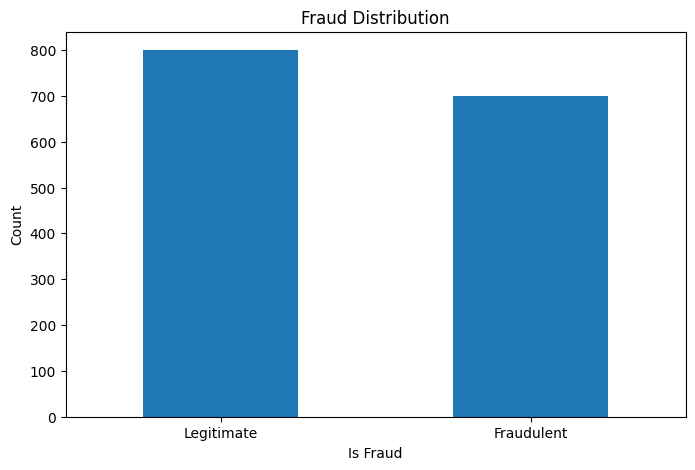

In [5]:
# Visualize fraud distribution
plt.figure(figsize=(8, 5))
df['is_fraud'].value_counts().plot(kind='bar')
plt.title('Fraud Distribution')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.xticks([0, 1], ['Legitimate', 'Fraudulent'], rotation=0)
plt.show()

## 3. Feature Engineering

In [6]:
# Create derived features
df['bp_ratio'] = df['systolic_bp'] / df['diastolic_bp']
df['fever'] = (df['temperature'] > 37.5).astype(int)
df['tachycardia'] = (df['pulse'] > 100).astype(int)
df['tachypnea'] = (df['respiratory_rate'] > 20).astype(int)
df['anemia'] = (df['hemoglobin'] < 13.0).astype(int)
df['leukopenia'] = (df['leukocyte'] < 4000).astype(int)
df['thrombocytopenia'] = (df['platelet'] < 150000).astype(int)

# Consistency checks
df['amount_severity_mismatch'] = ((df['diagnosis_severity'] == 1) & (df['claim_amount'] > 2000000)).astype(int)
df['vitals_severity_mismatch'] = ((df['diagnosis_severity'] == 3) & (df['fever'] == 0) & (df['tachycardia'] == 0)).astype(int)

print("✓ Feature engineering completed")
print(f"Total features: {df.shape[1] - 1}")  # -1 for target variable
df.head()

✓ Feature engineering completed
Total features: 20


,diagnosis_severity,systolic_bp,diastolic_bp,temperature,pulse,respiratory_rate,hemoglobin,leukocyte,platelet,hematocrit,...,is_fraud,bp_ratio,fever,tachycardia,tachypnea,anemia,leukopenia,thrombocytopenia,amount_severity_mismatch,vitals_severity_mismatch
0,2,148,110,39.6,103,26,15.1,9855,257529,46,...,0,1.345455,1,1,1,0,0,0,0,0
1,3,161,107,38.9,127,27,11.4,3236,107515,33,...,0,1.504673,1,1,1,1,1,1,0,0
2,3,180,101,38.7,115,26,11.7,2194,52397,36,...,0,1.782178,1,1,1,1,1,1,0,0
3,1,110,75,36.5,66,18,14.8,7221,325132,46,...,0,1.466667,0,0,0,0,0,0,0,0
4,3,172,97,38.9,116,26,9.6,2638,59006,32,...,0,1.773196,1,1,1,1,1,1,0,0


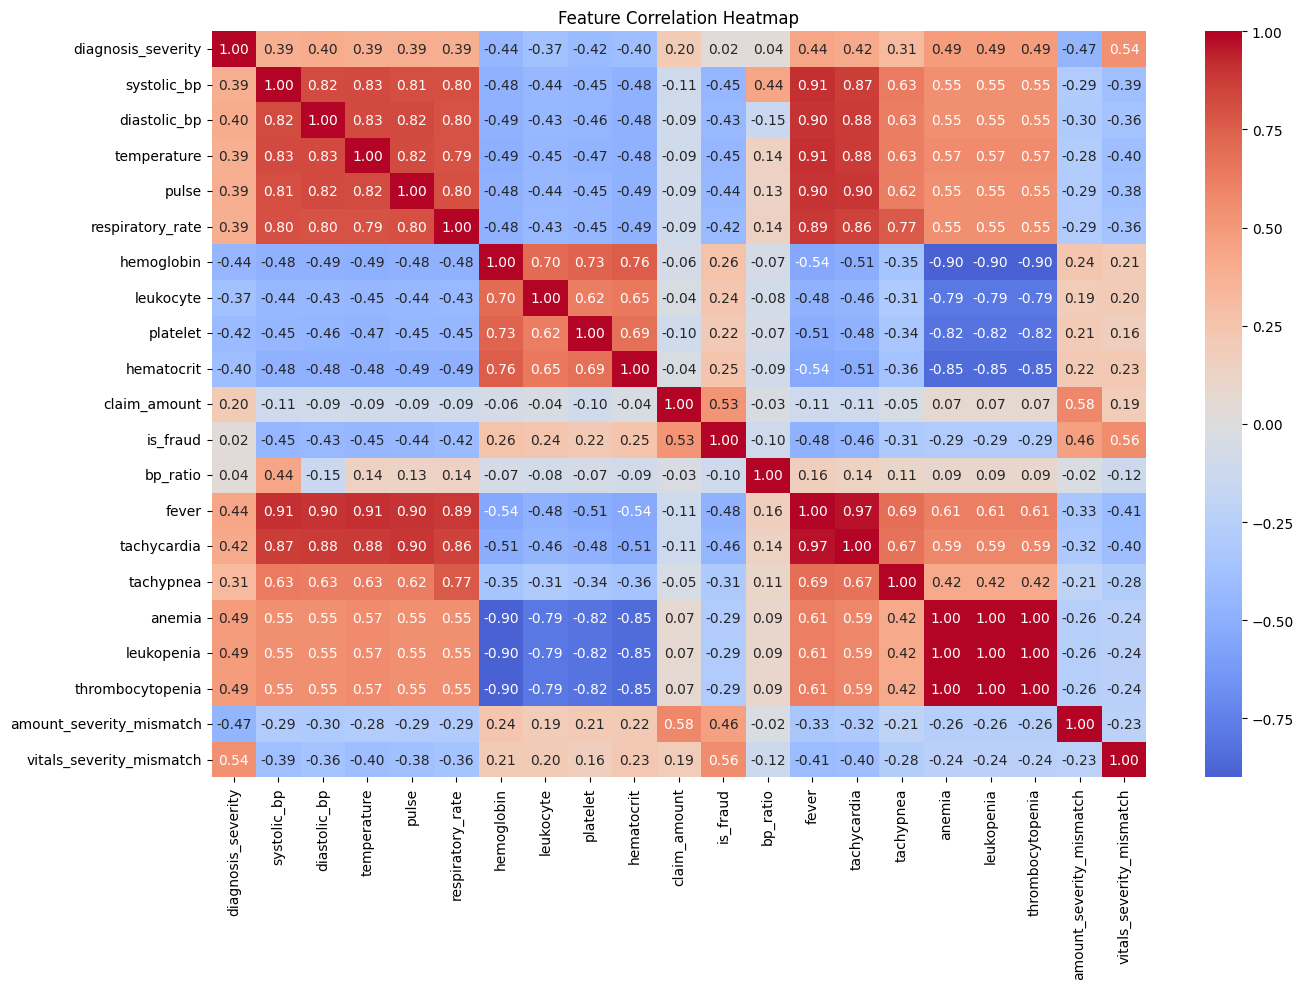


Correlation with fraud label:
is_fraud                    1.000000
vitals_severity_mismatch    0.558922
claim_amount                0.525831
amount_severity_mismatch    0.460770
hemoglobin                  0.260431
hematocrit                  0.250796
leukocyte                   0.240369
platelet                    0.218215
diagnosis_severity          0.023693
bp_ratio                   -0.102676
anemia                     -0.285714
leukopenia                 -0.285714
thrombocytopenia           -0.285714
tachypnea                  -0.306594
respiratory_rate           -0.422581
diastolic_bp               -0.430771
pulse                      -0.435204
systolic_bp                -0.447452
temperature                -0.449043
tachycardia                -0.459983
fever                      -0.481402
Name: is_fraud, dtype: float64


In [7]:
# Correlation heatmap
plt.figure(figsize=(14, 10))
correlation = df.corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# Show correlation with target
print("\nCorrelation with fraud label:")
print(correlation['is_fraud'].sort_values(ascending=False))

## 4. Data Preprocessing & Split

In [8]:
# Separate features and target
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures: {list(X.columns)}")

Features shape: (1500, 20)
Target shape: (1500,)

Features: ['diagnosis_severity', 'systolic_bp', 'diastolic_bp', 'temperature', 'pulse', 'respiratory_rate', 'hemoglobin', 'leukocyte', 'platelet', 'hematocrit', 'claim_amount', 'bp_ratio', 'fever', 'tachycardia', 'tachypnea', 'anemia', 'leukopenia', 'thrombocytopenia', 'amount_severity_mismatch', 'vitals_severity_mismatch']


In [9]:
# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining set fraud distribution:")
print(y_train.value_counts())
print(f"\nTest set fraud distribution:")
print(y_test.value_counts())

Training set: 1200 samples
Test set: 300 samples

Training set fraud distribution:
is_fraud
0    640
1    560
Name: count, dtype: int64

Test set fraud distribution:
is_fraud
0    160
1    140
Name: count, dtype: int64


In [10]:
# Scale numerical features
scaler = StandardScaler()

# Identify numerical columns to scale
numerical_cols = [
    'systolic_bp', 'diastolic_bp', 'temperature', 'pulse', 'respiratory_rate',
    'hemoglobin', 'leukocyte', 'platelet', 'hematocrit', 'claim_amount', 'bp_ratio'
]

# Fit scaler on training data
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

print("✓ Feature scaling completed")

✓ Feature scaling completed


## 5. Model Training - Random Forest

In [11]:
# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # Handle class imbalance
)

print("Training Random Forest model...")
rf_model.fit(X_train_scaled, y_train)
print("✓ Model training completed")

Training Random Forest model...
✓ Model training completed


## 6. Model Evaluation

In [12]:
# Predictions
y_train_pred = rf_model.predict(X_train_scaled)
y_test_pred = rf_model.predict(X_test_scaled)

y_train_proba = rf_model.predict_proba(X_train_scaled)[:, 1]
y_test_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Training set performance
print("="*60)
print("TRAINING SET PERFORMANCE")
print("="*60)
print(classification_report(y_train, y_train_pred, target_names=['Legitimate', 'Fraudulent']))
print(f"ROC-AUC Score: {roc_auc_score(y_train, y_train_proba):.4f}")

# Test set performance
print("\n" + "="*60)
print("TEST SET PERFORMANCE")
print("="*60)
print(classification_report(y_test, y_test_pred, target_names=['Legitimate', 'Fraudulent']))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_test_proba):.4f}")

TRAINING SET PERFORMANCE
              precision    recall  f1-score   support

  Legitimate       0.97      1.00      0.99       640
  Fraudulent       1.00      0.97      0.98       560

    accuracy                           0.99      1200
   macro avg       0.99      0.98      0.99      1200
weighted avg       0.99      0.99      0.99      1200

ROC-AUC Score: 1.0000

TEST SET PERFORMANCE
              precision    recall  f1-score   support

  Legitimate       0.98      1.00      0.99       160
  Fraudulent       1.00      0.97      0.99       140

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300

ROC-AUC Score: 0.9908


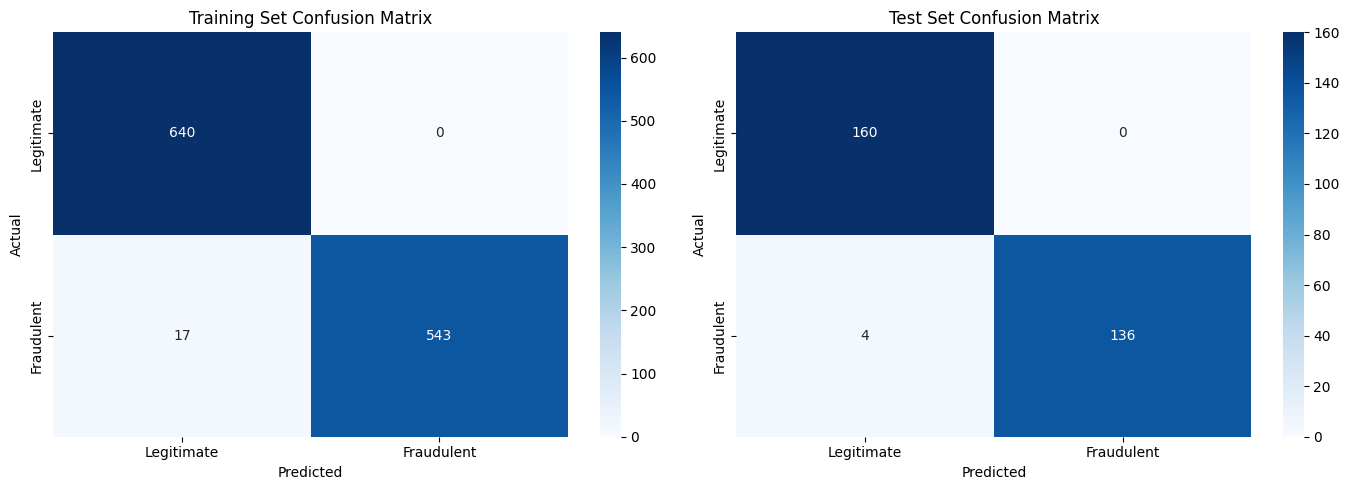

In [13]:
# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Training Set Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['Legitimate', 'Fraudulent'])
axes[0].set_yticklabels(['Legitimate', 'Fraudulent'])

# Test set
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Test Set Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_xticklabels(['Legitimate', 'Fraudulent'])
axes[1].set_yticklabels(['Legitimate', 'Fraudulent'])

plt.tight_layout()
plt.show()

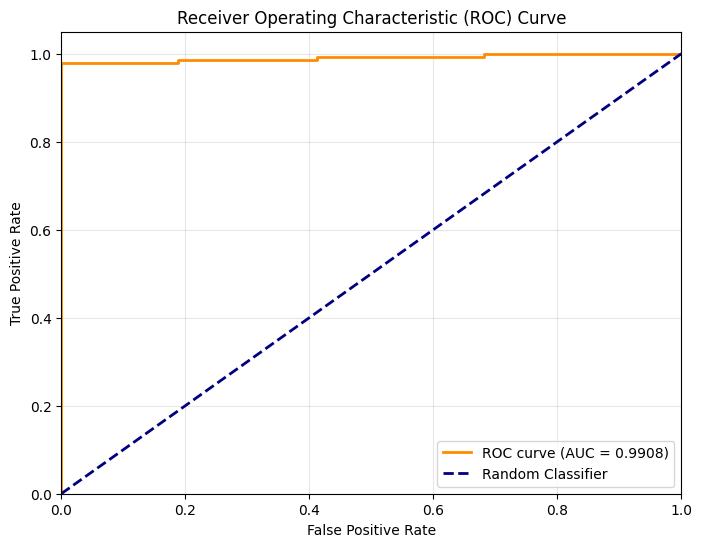

In [14]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

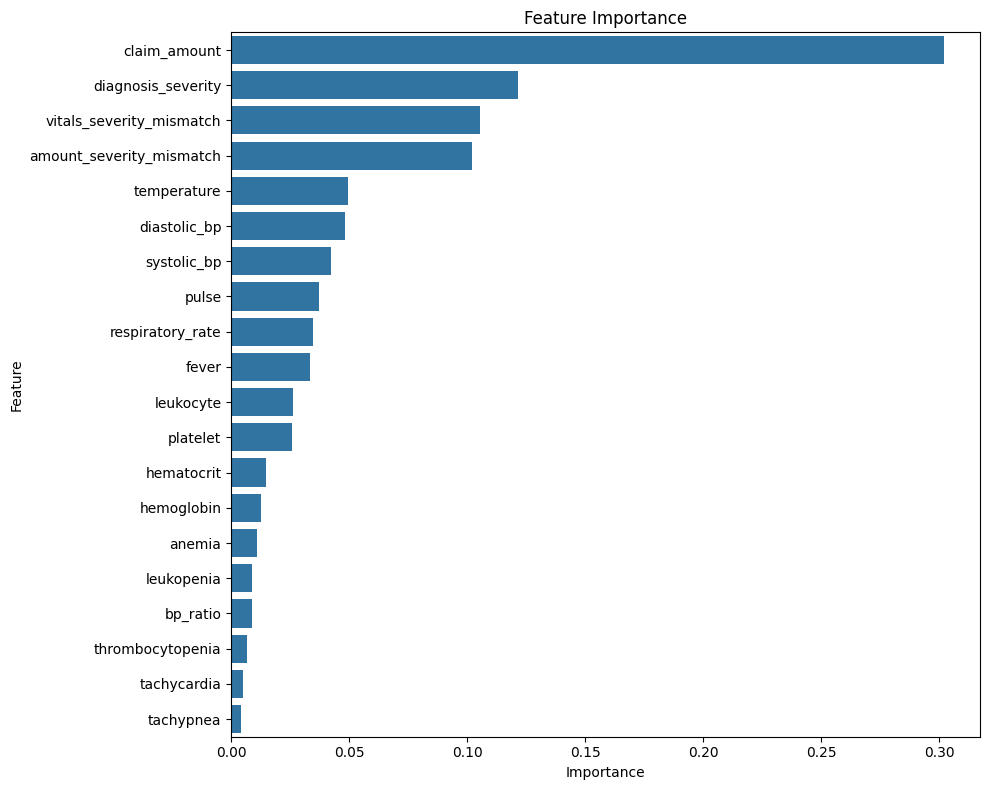


Top 10 Most Important Features:
                     feature  importance
10              claim_amount    0.302081
0         diagnosis_severity    0.121349
19  vitals_severity_mismatch    0.105465
18  amount_severity_mismatch    0.101915
3                temperature    0.049365
2               diastolic_bp    0.048195
1                systolic_bp    0.042479
4                      pulse    0.037160
5           respiratory_rate    0.034864
12                     fever    0.033366


In [15]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

## 7. Save Model

In [16]:
# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save model
model_path = '../models/fraud_detection_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(rf_model, f)
print(f"✓ Model saved to {model_path}")

# Save scaler
scaler_path = '../models/scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"✓ Scaler saved to {scaler_path}")

# Save feature names for reference
feature_names_path = '../models/feature_names.json'
with open(feature_names_path, 'w') as f:
    json.dump(list(X.columns), f)
print(f"✓ Feature names saved to {feature_names_path}")

print("\n" + "="*60)
print("MODEL TRAINING COMPLETED SUCCESSFULLY!")
print("="*60)
print(f"Test Set Accuracy: {(y_test_pred == y_test).mean():.2%}")
print(f"Test Set ROC-AUC: {roc_auc:.4f}")
print("\nModel is ready for inference in the fraud detection pipeline.")

✓ Model saved to ../models/fraud_detection_model.pkl
✓ Scaler saved to ../models/scaler.pkl
✓ Feature names saved to ../models/feature_names.json

MODEL TRAINING COMPLETED SUCCESSFULLY!
Test Set Accuracy: 98.67%
Test Set ROC-AUC: 0.9908

Model is ready for inference in the fraud detection pipeline.
